In [1]:
from functools import lru_cache
import dtreeviz.trees as dtreeviz
import graphviz
import ipywidgets as widgets
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import SVG, display
from ipywidgets import Button, IntSlider, interactive
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from sklearn import preprocessing, tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import (
    KBinsDiscretizer,
    LabelEncoder,
    MinMaxScaler,
    Normalizer,
    OneHotEncoder,
    OrdinalEncoder,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
)
from sklearn.model_selection import StratifiedKFold
sns.set()



# Primer preprocesamiento simple, acorde al TP1

In [2]:
from preprocessing import obtener_datasets
from preprocessing import aplicar_preparacion
from preprocessing import conversion_numerica

df, df_holdout = obtener_datasets()
X_df, y_df = aplicar_preparacion(df)


# acá solo convierto simplemente a numerico.. primer preprocessing!
X_df = conversion_numerica(X_df) 


## Plot de grafico treedecision como lo hicieron en la clase práctica (CODIGO COMENTADO)


In [3]:

'''

def get_tree(X, y, max_depth=5, min_samples_leaf=10, random_state = 117):
    """Devuelve un árbol entrenado."""
    clf = tree.DecisionTreeClassifier(
        random_state=random_state, max_depth=max_depth, min_samples_leaf=min_samples_leaf
    )
    clf.fit(X, y)
    return clf


def plot_tree(max_depth, min_samples_leaf,random_state):
    """Interfaz interactiva para visualizar un árbol entrenado."""
    clf = get_tree(X_train, y_target, max_depth, min_samples_leaf,random_state)
    dot_data = tree.export_graphviz(
        clf,
        out_file=None,
        feature_names=X_train.columns,
        filled=True,
        rounded=True,
        special_characters=True,
    )
    graph = graphviz.Source(dot_data)
    display(SVG(graph.pipe(format='svg')))
    graph.format = "svg"
    graph.render("arbol_formado")
    pred = clf.predict(X_train)
    display(accuracy_score(y_target, pred))
    display(sorted(list(zip(X_train.columns, clf.feature_importances_)), key=lambda x: -x[1]))


inter = interactive(
    plot_tree,
    max_depth=IntSlider(min=1, max=50, value=10),
    min_samples_leaf=IntSlider(min=1, max=500, value=500),
    random_state=IntSlider(min=1, max=255, value=10),
#{'criterion': 'gini', 'max_depth': 10}
)

display(inter)

'''


'\n\ndef get_tree(X, y, max_depth=5, min_samples_leaf=10, random_state = 117):\n    """Devuelve un árbol entrenado."""\n    clf = tree.DecisionTreeClassifier(\n        random_state=random_state, max_depth=max_depth, min_samples_leaf=min_samples_leaf\n    )\n    clf.fit(X, y)\n    return clf\n\n\ndef plot_tree(max_depth, min_samples_leaf,random_state):\n    """Interfaz interactiva para visualizar un árbol entrenado."""\n    clf = get_tree(X_train, y_target, max_depth, min_samples_leaf,random_state)\n    dot_data = tree.export_graphviz(\n        clf,\n        out_file=None,\n        feature_names=X_train.columns,\n        filled=True,\n        rounded=True,\n        special_characters=True,\n    )\n    graph = graphviz.Source(dot_data)\n    display(SVG(graph.pipe(format=\'svg\')))\n    graph.format = "svg"\n    graph.render("arbol_formado")\n    pred = clf.predict(X_train)\n    display(accuracy_score(y_target, pred))\n    display(sorted(list(zip(X_train.columns, clf.feature_importances_)

## Entreno.. Matriz de confusión.. Métricas

Con Cross validation de 5 folds, y antes dividio en 10% val-test para predecir con test despues de fitear

Accuracy sobre test:  0.8348173165489714


{'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 535}

              precision    recall  f1-score   support

  Bajo valor       0.94      0.86      0.90      2679
  Alto valor       0.52      0.74      0.61       578

    accuracy                           0.83      3257
   macro avg       0.73      0.80      0.75      3257
weighted avg       0.86      0.83      0.84      3257



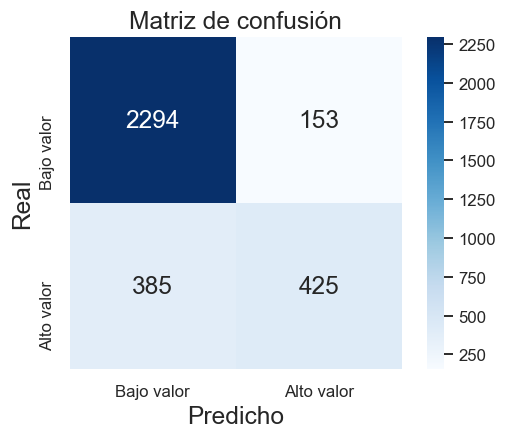

In [4]:
XX_train, XX_test, yy_train, yy_test = train_test_split(X_df, y_df, test_size=0.10, random_state=10)

params = {
    'max_depth': np.arange(1, 5),
    'min_samples_leaf': np.arange(535,536),
    "criterion": ["gini", "entropy"],
}

clf = tree.DecisionTreeClassifier(random_state=10)
clf = GridSearchCV(clf, params,scoring='f1', cv= 5, n_jobs = -1)

clf.fit(XX_train, yy_train)
yy_pred = clf.predict(XX_test)

print("Accuracy sobre test: ", accuracy_score(yy_pred, yy_test))
display(clf.best_params_)
print(classification_report(yy_pred, yy_test, target_names=["Bajo valor", "Alto valor"]))

from preprocessing import graficar_matriz_confusion
graficar_matriz_confusion(yy_test, yy_pred)

## Grafico ROC



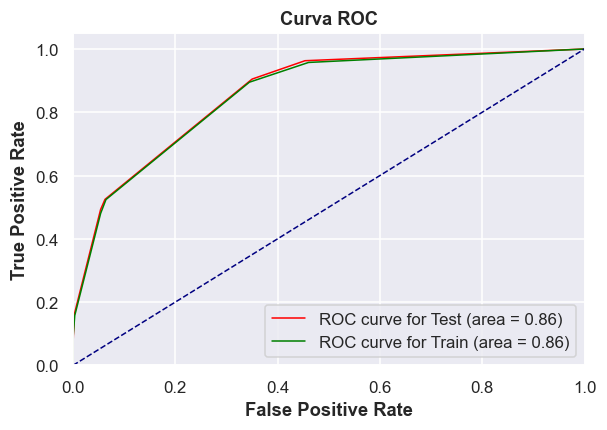

In [5]:
from preprocessing import plot_roc_curves
plot_roc_curves(clf, XX_test, yy_test, XX_train, yy_train)

## Probando con StratifiedKFold pero no veo diferencias..

0.8348173165489714

{'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 535}

              precision    recall  f1-score   support

  Bajo valor       0.94      0.86      0.90      2679
  Alto valor       0.52      0.74      0.61       578

    accuracy                           0.83      3257
   macro avg       0.73      0.80      0.75      3257
weighted avg       0.86      0.83      0.84      3257



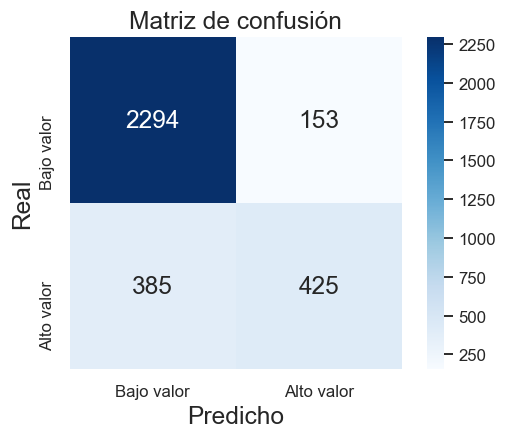

In [6]:
XX_train, XX_test, yy_train, yy_test = train_test_split(X_df, y_df, test_size=0.10, random_state=10)

params = {
    'max_depth': np.arange(1, 5),
    'min_samples_leaf': np.arange(535,536),
    "criterion": ["gini", "entropy"],

}

cv = StratifiedKFold(n_splits=10).split(XX_train,yy_train)
clf = tree.DecisionTreeClassifier(random_state=10)
clf = GridSearchCV(clf, params, scoring='f1', cv=cv, n_jobs = -1)

clf.fit(XX_train, yy_train)
yy_pred = clf.predict(XX_test)

display(accuracy_score(yy_pred, yy_test))
display(clf.best_params_)
print(classification_report(yy_pred, yy_test, target_names=["Bajo valor", "Alto valor"]))
from preprocessing import graficar_matriz_confusion

graficar_matriz_confusion(yy_test, yy_pred)

0.8348173165489714

{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 535}

              precision    recall  f1-score   support

  Bajo valor       0.94      0.86      0.90      2679
  Alto valor       0.52      0.74      0.61       578

    accuracy                           0.83      3257
   macro avg       0.73      0.80      0.75      3257
weighted avg       0.86      0.83      0.84      3257



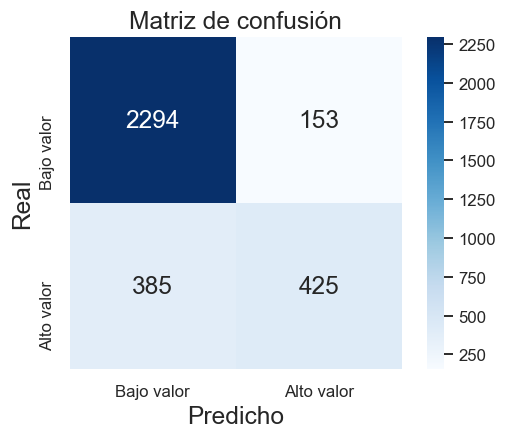

In [7]:
from sklearn.model_selection import RepeatedStratifiedKFold

XX_train, XX_test, yy_train, yy_test = train_test_split(X_df, y_df, test_size=0.10, random_state=10)

params = {
    'max_depth': np.arange(1, 5),
    'min_samples_leaf': np.arange(535,536),
    "criterion": ["gini", "entropy"],

}
cv2 = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1).split(XX_train,yy_train)

#cv = StratifiedKFold(n_splits=10).split(XX_train,yy_train)
clf = tree.DecisionTreeClassifier(random_state=10)
clf = GridSearchCV(clf, params, scoring='f1', cv=cv2, n_jobs = -1)

clf.fit(XX_train, yy_train)
yy_pred = clf.predict(XX_test)

display(accuracy_score(yy_pred, yy_test))
display(clf.best_params_)
print(classification_report(yy_pred, yy_test, target_names=["Bajo valor", "Alto valor"]))
from preprocessing import graficar_matriz_confusion
graficar_matriz_confusion(yy_test, yy_pred)

### Otra forma distinta de apicar StratifiedKFold (CODIGO COMENTADO)

In [8]:
# FUENTE: https://www.kaggle.com/ariadneadler/xgboost-gridsearchcv-stratified-k-fold-top-5#Prediction

'''
params = {
    'max_depth': np.arange(1, 10),
    'min_samples_leaf': np.arange(500,536),
    "criterion": ["gini", "entropy"],
}
i=1
kf = StratifiedKFold(n_splits=5,random_state=10,shuffle=True)
for train_index,test_index in kf.split(X_reduced,y_df):
     print('\n#{} of #{} Stratified-KFold'.format(i,kf.n_splits))
     xtr,xvl = X_reduced.loc[train_index],X_reduced.loc[test_index]
     ytr,yvl = y_df[train_index],y_df[test_index]
     clf = tree.DecisionTreeClassifier(random_state=10)
     model = GridSearchCV(clf, params, cv=5, scoring= 'f1')
     model.fit(xtr, ytr)
     print (model.best_params_)
     pred=model.predict(xvl)
     print('accuracy_score',accuracy_score(yvl,pred))
     print('roc_auc_score',roc_auc_score(yvl, pred))
     print(classification_report(yvl, pred, target_names=["Bajo valor", "Alto valor"]))
     graficar_matriz_confusion(yvl, pred)
     i+=1

'''

'\nparams = {\n    \'max_depth\': np.arange(1, 10),\n    \'min_samples_leaf\': np.arange(500,536),\n    "criterion": ["gini", "entropy"],\n}\ni=1\nkf = StratifiedKFold(n_splits=5,random_state=10,shuffle=True)\nfor train_index,test_index in kf.split(X_reduced,y_df):\n     print(\'\n#{} of #{} Stratified-KFold\'.format(i,kf.n_splits))\n     xtr,xvl = X_reduced.loc[train_index],X_reduced.loc[test_index]\n     ytr,yvl = y_df[train_index],y_df[test_index]\n     clf = tree.DecisionTreeClassifier(random_state=10)\n     model = GridSearchCV(clf, params, cv=5, scoring= \'f1\')\n     model.fit(xtr, ytr)\n     print (model.best_params_)\n     pred=model.predict(xvl)\n     print(\'accuracy_score\',accuracy_score(yvl,pred))\n     print(\'roc_auc_score\',roc_auc_score(yvl, pred))\n     print(classification_report(yvl, pred, target_names=["Bajo valor", "Alto valor"]))\n     graficar_matriz_confusion(yvl, pred)\n     i+=1\n\n'

## Dividiendo con Holdout de 5%, pero entreno con Train y Test

In [9]:
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X_df, y_df, random_state=117, test_size=0.05, stratify=y_df
)

Best params {'criterion': 'entropy', 'max_depth': 3}
  train score: 0.8316691881964532
   test score, forma 1: 0.845830639948287
   test score, forma 2: 0.845830639948287
holdout score: 0.8250460405156538
              precision    recall  f1-score   support

  Bajo valor       0.94      0.87      0.90      2554
  Alto valor       0.54      0.75      0.63       540

    accuracy                           0.85      3094
   macro avg       0.74      0.81      0.77      3094
weighted avg       0.87      0.85      0.85      3094



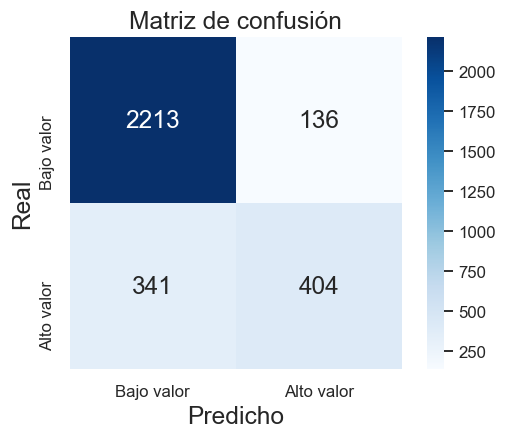

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, random_state=10, test_size=0.10, stratify=y_train
)

params = {
    'max_depth': np.arange(1, 5),
    "criterion": ["gini", "entropy"],
}

clf = tree.DecisionTreeClassifier(random_state=10, min_samples_leaf=535 ,)

rgscv = GridSearchCV(
    clf, params, scoring='accuracy', n_jobs=-1, cv=5, return_train_score=True
).fit(X_train, y_train)

y_pred = rgscv.predict(X_test)

print(f"Best params {rgscv.best_params_}")
print(f"  train score: {rgscv.best_score_}")
print(f"   test score, forma 1: {rgscv.score(X_test, y_test)}")
print(f"   test score, forma 2: {accuracy_score(y_test, y_pred)}")
print(f"holdout score: {rgscv.score(X_holdout, y_holdout)}")

print(classification_report(y_pred, y_test, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(y_test, y_pred)

# Segundo preprocesamiento

In [11]:
from preprocessing import obtener_datasets
from preprocessing import aplicar_preparacion
from preprocessing import conversion_numerica

df, df_holdout = obtener_datasets()
X_df, y_df = aplicar_preparacion(df)
X_df = conversion_numerica(X_df) 



---------------------------------------------------------------------
Aplicando preprocesamiento # 1 con Preprocesamiento de StandardScaler()
Accuracy sobre test:  0.8348173165489714


{'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 535}

              precision    recall  f1-score   support

  Bajo valor       0.94      0.86      0.90      2679
  Alto valor       0.52      0.74      0.61       578

    accuracy                           0.83      3257
   macro avg       0.73      0.80      0.75      3257
weighted avg       0.86      0.83      0.84      3257



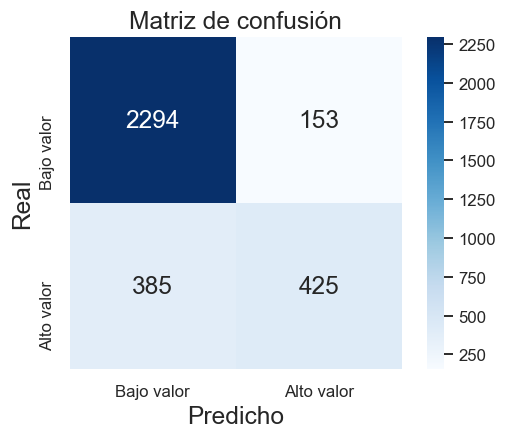


---------------------------------------------------------------------
Aplicando preprocesamiento # 2 con Preprocesamiento de MinMaxScaler()
Accuracy sobre test:  0.8348173165489714


{'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 535}

              precision    recall  f1-score   support

  Bajo valor       0.94      0.86      0.90      2679
  Alto valor       0.52      0.74      0.61       578

    accuracy                           0.83      3257
   macro avg       0.73      0.80      0.75      3257
weighted avg       0.86      0.83      0.84      3257



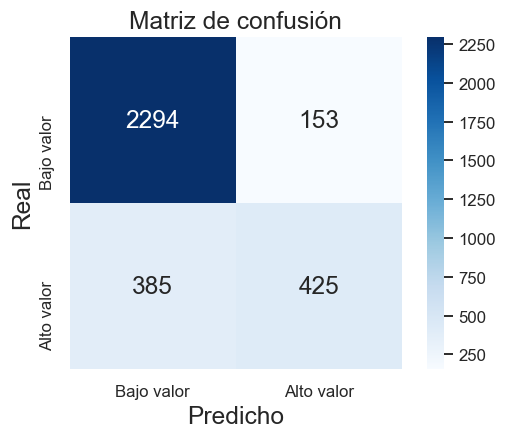


---------------------------------------------------------------------
Aplicando preprocesamiento # 3 con Preprocesamiento de RobustScaler()
Accuracy sobre test:  0.8348173165489714


{'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 535}

              precision    recall  f1-score   support

  Bajo valor       0.94      0.86      0.90      2679
  Alto valor       0.52      0.74      0.61       578

    accuracy                           0.83      3257
   macro avg       0.73      0.80      0.75      3257
weighted avg       0.86      0.83      0.84      3257



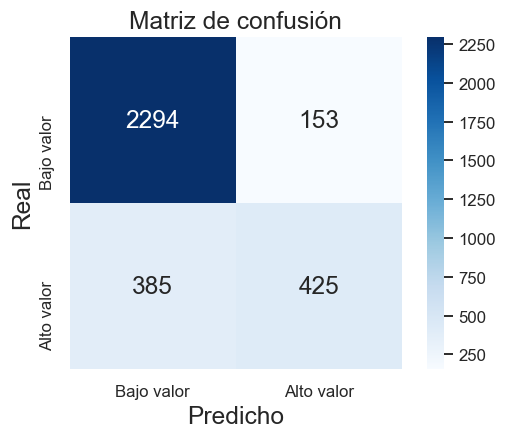


---------------------------------------------------------------------
Aplicando preprocesamiento # 4 con Preprocesamiento de PowerTransformer()
Accuracy sobre test:  0.8348173165489714


{'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 535}

              precision    recall  f1-score   support

  Bajo valor       0.94      0.86      0.90      2679
  Alto valor       0.52      0.74      0.61       578

    accuracy                           0.83      3257
   macro avg       0.73      0.80      0.75      3257
weighted avg       0.86      0.83      0.84      3257



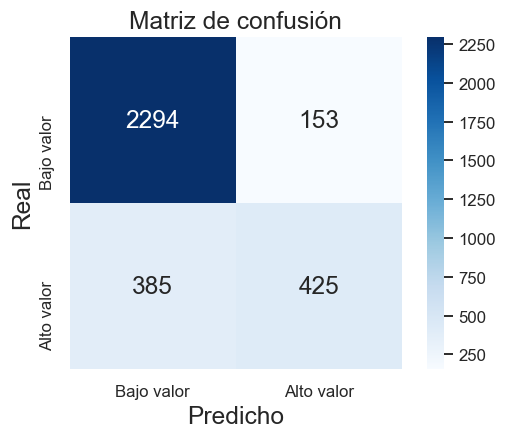


---------------------------------------------------------------------
Aplicando preprocesamiento # 5 con Preprocesamiento de Normalizer()
Accuracy sobre test:  0.8311329444273872


{'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 535}

              precision    recall  f1-score   support

  Bajo valor       0.94      0.85      0.89      2697
  Alto valor       0.51      0.73      0.60       560

    accuracy                           0.83      3257
   macro avg       0.72      0.79      0.75      3257
weighted avg       0.86      0.83      0.84      3257



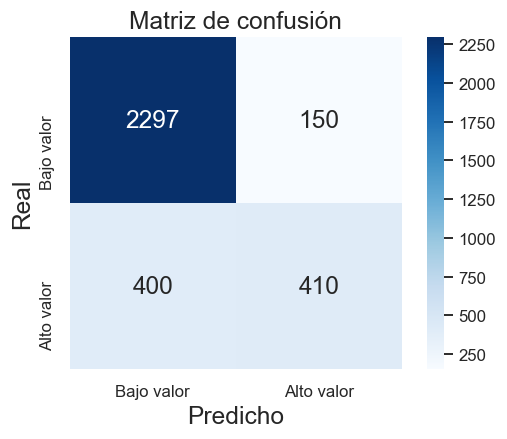

In [12]:
from sklearn.preprocessing import (
    KBinsDiscretizer,
    LabelEncoder,
    MinMaxScaler,
    Normalizer,
    OneHotEncoder,
    OrdinalEncoder,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
)

scalers = [
    StandardScaler(),  # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
    MinMaxScaler(),  # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
    RobustScaler(),  # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html
    PowerTransformer(),  # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html
    Normalizer(),  # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html
]

for count, scaler in enumerate(scalers):
    print("\n---------------------------------------------------------------------")
    print("Aplicando preprocesamiento #",count+1, "con Preprocesamiento de", scaler)
    scaled = scaler.fit_transform(X_df)
    X_df_scaled = pd.DataFrame(scaled, index=X_df.index, columns=X_df.columns)
    
    XX_train, XX_test, yy_train, yy_test = train_test_split(X_df_scaled, y_df, test_size=0.10, random_state=10)

    params = {
        'max_depth': np.arange(1, 5),
        'min_samples_leaf': np.arange(535,536),
        "criterion": ["gini", "entropy"],
    }

    clf = tree.DecisionTreeClassifier(random_state=10)
    clf = GridSearchCV(clf, params, cv= 5, n_jobs = -1)

    clf.fit(XX_train, yy_train)
    yy_pred = clf.predict(XX_test)

    print("Accuracy sobre test: ", accuracy_score(yy_pred, yy_test))
    display(clf.best_params_)
    print(classification_report(yy_pred, yy_test, target_names=["Bajo valor", "Alto valor"]))

    from preprocessing import graficar_matriz_confusion
    graficar_matriz_confusion(yy_test, yy_pred)
    

El unico que tiene "sentido" es la normalización. Apeeeenas se modifico. Pero hasta ahí..

A los demás, al arbol no le afecta! Tiene sentido... para KNN por ejemplo sí debemos aplicar algo ahí con eso!


# Tercer preprocesamiento (sin sentido)

Accuracy sobre test:  0.8348173165489714


{'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 535}

              precision    recall  f1-score   support

  Bajo valor       0.94      0.86      0.90      2679
  Alto valor       0.52      0.74      0.61       578

    accuracy                           0.83      3257
   macro avg       0.73      0.80      0.75      3257
weighted avg       0.86      0.83      0.84      3257



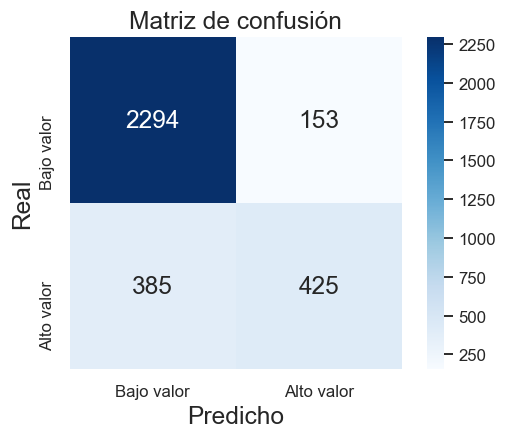

In [13]:

from sklearn.feature_selection import RFECV

clf = tree.DecisionTreeClassifier(criterion = 'gini', max_depth= 3, min_samples_leaf = 535, random_state=10)
selector = RFECV(
    estimator=clf,
    min_features_to_select=10,
    step=5,
    n_jobs=-1,
    scoring="f1",
    cv=5,
)
selector = selector.fit(X_df, y_df)

f = selector.get_support(1) 
X_reduced = X_df[X_df.columns[f]] 



XX_train, XX_test, yy_train, yy_test = train_test_split(X_reduced, y_df, test_size=0.10, random_state=10)

params = {
    'max_depth': np.arange(1, 5),
    'min_samples_leaf': np.arange(535,536),
    "criterion": ["gini", "entropy"],
}

clf = tree.DecisionTreeClassifier(random_state=10)
clf = GridSearchCV(clf, params, cv= 5, n_jobs = -1)

clf.fit(XX_train, yy_train)
yy_pred = clf.predict(XX_test)

print("Accuracy sobre test: ", accuracy_score(yy_pred, yy_test))
display(clf.best_params_)
print(classification_report(yy_pred, yy_test, target_names=["Bajo valor", "Alto valor"]))

from preprocessing import graficar_matriz_confusion
graficar_matriz_confusion(yy_test, yy_pred)

# Cuarto preprocesamietno

Esto es demasiado random..no especifiqué hiperparametros en RandomForess

Accuracy sobre test:  0.8348173165489714


{'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 535}

              precision    recall  f1-score   support

  Bajo valor       0.94      0.86      0.90      2679
  Alto valor       0.52      0.74      0.61       578

    accuracy                           0.83      3257
   macro avg       0.73      0.80      0.75      3257
weighted avg       0.86      0.83      0.84      3257



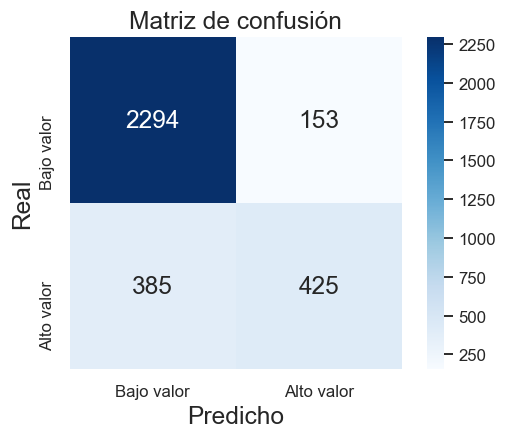

In [14]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
selector = RFECV(
    estimator=clf,
    min_features_to_select=10,
    step=5,
    n_jobs=-1,
    scoring="f1",
    cv=5,
)
selector = selector.fit(X_df, y_df)

f = selector.get_support(1) 
X_reduced = X_df[X_df.columns[f]] 


XX_train, XX_test, yy_train, yy_test = train_test_split(X_reduced, y_df, test_size=0.10, random_state=10)

params = {
    'max_depth': np.arange(1, 5),
    'min_samples_leaf': np.arange(535,536),
    "criterion": ["gini", "entropy"],
}

clf = tree.DecisionTreeClassifier(random_state=10)
clf = GridSearchCV(clf, params, cv= 5, n_jobs = -1)

clf.fit(XX_train, yy_train)
yy_pred = clf.predict(XX_test)

print("Accuracy sobre test: ", accuracy_score(yy_pred, yy_test))
display(clf.best_params_)
print(classification_report(yy_pred, yy_test, target_names=["Bajo valor", "Alto valor"]))

from preprocessing import graficar_matriz_confusion
graficar_matriz_confusion(yy_test, yy_pred)

# Quinto preprocesamiento  -- expansión --  (otra idea posible)

Podria ser con una extensión de features con nuevos features!
Es decir: 

Crear features polinomicos https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

Ver si al tener más features pero multiplicandolos, y tal cosa => quizás nos dé mas accuracy al encontrar esa relación de esa forma!

# Sexto preprocesamiento -- expansión -- (otra idea posible)

Atraves de Clusters!!

De alguna manera tener buenos clusters armados, ya en el otro notebook de 'tp_FIUFIP_parte1_extras.ipynb' estuve viendo como armar un buen cluster

Pero el tema es que, tenemos 40 features el cual seguramente hay features irrelevantes, por ende no ayudaria en nada a la formación del cluster.

Entonces deberiamos hablar con Juan y preguntar si es buena la idea de reducir la dimensionalidad con RFECV, o sino aplicar PCA... pero PCA no te da buena % varianza mantenida. 

Con MDS, o ISOMAP ya intenté y no lo puedo hacer andar! No termina nunca! 
Investigar bien con Juan cómo correr MDS sobre este dataset gigante 

### Idea: 
Teniendo un buen cluster, agregás esa nueva featre al dataset indicandonos el numero de cluster para cada instancia y entrenamos

Puede que ayude un poco al modelo tener datos bien estructurados mediantes clusters bien formados


### Dificil armar la matriz de similitud

O bueno.. necesitas tus datos en 2D!! 

Pero se podria usar una metrica de coeficiente de sillhouette para evaluar el cluster! 


# Septimo preprocesamiento -- expansión -- (otra idea posible)

se generaron nuevas features en ciertos analisis del TP1. En EL preprocessing.py están dichas funciones que generan esas nuevas features.

Podriamos usar esas nuevas features como preprocessing y ver si mejora o no 